## Lattice and Tensile Test examples

Nematic order is a measure of the average direction of molecules. It is a value between 0 and 1 with a value above 0.3 indicating some form of order within a system. A perfectly ordered system in which the orientations of all particles is alligned will have an order parameter of 1.0 as with the provided lattice melt test graph below.

In [1]:
from nematic_order import nematic_order
import matplotlib.pyplot as plt
import numpy as np
from cmeutils.visualize import FresnelGSD

/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/mdtraj/formats/__init__.py:13: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from mdtraj.formats.trr import TRRTrajectoryFile


/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/jbieri/miniforge3/envs/flowerMD/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Text(0.5, 1.0, 'Lattice melt test')

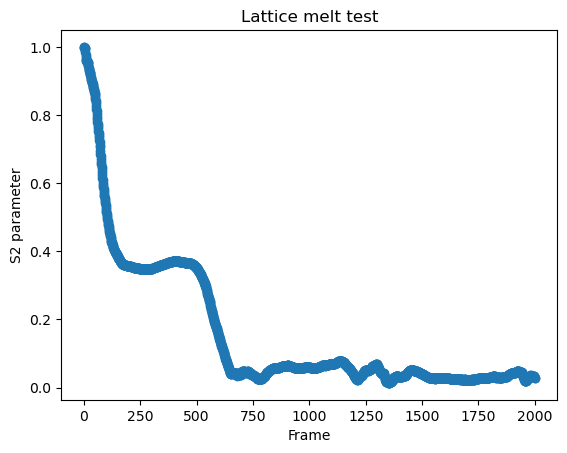

In [2]:
lattice_orders,director = nematic_order("/home/jbieri/CME_lab/projects/SIC/preliminary-work/pps/coarse-graining/pps-melt-cg.gsd")
plt.scatter(range(len(lattice_orders)),lattice_orders)
plt.xlabel("Frame")
plt.ylabel("S2 parameter")
plt.title("Lattice melt test")

Text(0.5, 1.0, 'Tensile test')

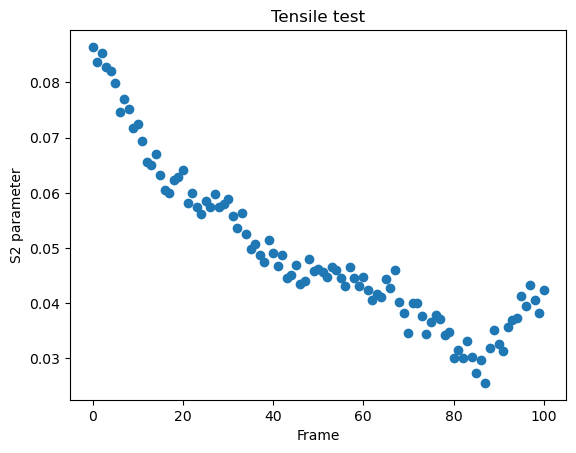

In [3]:
# Tensile test
tensile_orders,director = nematic_order("/home/jbieri/CME_lab/projects/SIC/preliminary-work/pps/coarse-graining/given-pps-cg.gsd")
plt.scatter(range(len(tensile_orders)),tensile_orders)
plt.xlabel("Frame")
plt.ylabel("S2 parameter")
plt.title("Tensile test")

## Bond vectors in opposite directions have the same nematic order

This short example simulation will be used to produce a GSD file with a resulting nematic order that should decrease as the simulation progresses. A graph showing the direction of the director vector of the first frame (as vizualised) will be produced. The nematic order of the initial frame is not 1 as the system is not fully coarse grained. Utilizing GRiTS to coarsegrain beyond removing hydrogens will cause the first frame to have an order of approximately 1.

In [4]:
from flowermd.library import PPS, OPLS_AA_PPS, BeadSpring
import warnings
warnings.filterwarnings('ignore')
import flowermd
import hoomd
from flowermd.base import Molecule, Lattice, Simulation
from cmeutils.visualize import FresnelGSD
import gsd
import gsd.hoomd

molecule = PPS(num_mols=2, lengths=10) # Designating number of molecules and their length

box = Lattice(molecules=molecule, x = 2, y = 2, n = 1) # Box size and type
box.apply_forcefield(r_cut=2.5, force_field=OPLS_AA_PPS(), auto_scale=True,remove_charges=True, remove_hydrogens=True)

No charged group detected, skipping electrostatics.


In [5]:
box.to_gsd('unrotated-system.gsd')

In [6]:
old_snap = box.hoomd_snapshot
old_pos = old_snap.particles.position[:70]
R = np.array([[-1,0,0],[0,1,0],[0,0,-1]])

In [7]:
new_pos = np.dot(old_pos, R.T)
print(new_pos[0], old_pos[0])

[ 1.14805984 -1.61828244  8.40081882] [-1.1480598 -1.6182824 -8.400819 ]


In [8]:
old_snap.particles.position[:70] = new_pos

In [9]:
with gsd.hoomd.open("second-after-rotation-snapshot.gsd", "w") as traj:
    traj.append(old_snap)


In [10]:
box.hoomd_snapshot
box.hoomd_snapshot.particles.position[:70] = np.dot(box.hoomd_snapshot.particles.position[:70], R.T)
hoomd_forces = box.hoomd_forcefield
hoomd_forces
lj_force = hoomd_forces[3]
cpu = hoomd.device.CPU()

In [11]:
sim = Simulation(initial_state='second-after-rotation-snapshot.gsd', forcefield=box.hoomd_forcefield,reference_values=box.reference_values,gsd_write_freq=100, log_write_freq=100, device=cpu, gsd_file_name='small-pps-melt.gsd')

Initializing simulation state from a GSD file.


In [12]:
sim.save_restart_gsd('rotated-system.gsd')

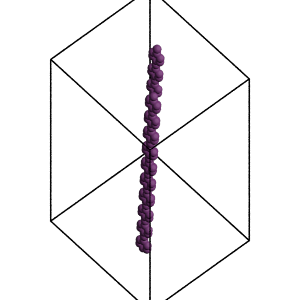

In [17]:
sim_visualizer = FresnelGSD(gsd_file='unrotated-system.gsd', view_axis=(1, 1, 1))
sim_visualizer.height = 20
sim_visualizer.view()

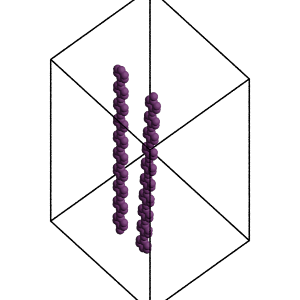

In [14]:
sim_visualizer2 = FresnelGSD(gsd_file='rotated-system.gsd', frame=-1, view_axis=(1, 1, 1))
sim_visualizer2.height = 20
sim_visualizer2.view()

Plotting the nematic director of the small melt example

The difference between the nematic orders of the systems is 0.00026739


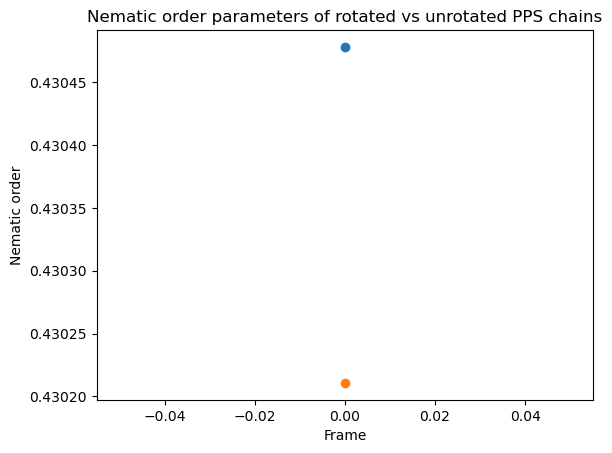

In [15]:
lattice_orders1,director1 = nematic_order('unrotated-system.gsd')
lattice_orders2,director2 = nematic_order('rotated-system.gsd')
plt.scatter(range(len(lattice_orders1)),lattice_orders1)
plt.scatter(range(len(lattice_orders2)),lattice_orders2)
plt.xlabel('Frame')
plt.ylabel('Nematic order')
plt.title('Nematic order parameters of rotated vs unrotated PPS chains')
print('The difference between the nematic orders of the systems is', f"{(lattice_orders1[0] - lattice_orders2[0]):.5}")

As seen in the graph and text above, there is not a significant difference between these measurements, indicating that the physical orientation of the molecules matters not. Orientations between atoms of the molecules is what matters most in determining the average direction used as a reference for nematic order calculations.